In [111]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.optimize as opt
from training.util_prepare import get_prediction_matrix
%load_ext autoreload
%autoreload 2

sys.path.append("../")
from training.util_prediction import get_coordinate_list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## import data

In [18]:
dataset = "../data/spots_synt_harder_e4cd83b6.npz"
with np.load(dataset, allow_pickle=True) as data:
        train_x = data["x_train"]
        valid_x = data["x_valid"]
        test_x = data["x_test"]
        train_y = data["y_train"]
        valid_y = data["y_valid"]
        test_y = data["y_test"]

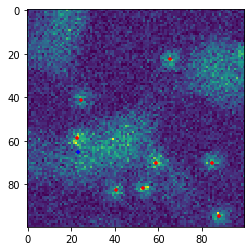

In [139]:
idx = 10
init = 0
init_1 = 0
size = 100
image = train_x[idx]
image = image[init:(init+size),init_1:(init_1+size)]
mask = train_y[idx]
mask = mask[int(init/4):int((init+size)/4),int(init_1/4):int((init_1+size)/4)]

plt.imshow(image)
coordList = get_coordinate_list(mask,512,128)
plt.scatter(coordList[...,0],coordList[...,1],marker="+",color='r',s=20)
plt.scatter(y0,x0,marker="+",color='b',s=20)


In [153]:
def gauss_2d(xy, amplitude, x0, y0, sigma_xy, offset):
    """2D gaussian."""
    x, y = xy
    x0 = float(x0)
    y0 = float(y0)
    gauss = offset + amplitude * np.exp(
        -(((x - x0) ** (2) / (2 * sigma_xy ** (2))) + ((y - y0) ** (2) / (2 * sigma_xy ** (2))))
    )
    return gauss


def gauss_single_spot(image: np.ndarray, x_coord: float, y_coord: float, cell_size: int):
    """Gaussian prediction on a single crop centred on spot."""
    start_dim1 = np.max(int(np.round(y_coord - cell_size // 2)), 0)
    end_dim1 = np.min([start_dim1 + cell_size, len(image) - 1])

    start_dim2 = np.max(int(np.round(x_coord - cell_size // 2)), 0)
    end_dim2 = np.min([start_dim2 + cell_size, len(image) - 1])
    crop = image[start_dim1:end_dim1, start_dim2:end_dim2]

    x = np.arange(0, crop.shape[1], 1)
    y = np.arange(0, crop.shape[0], 1)
    xx, yy = np.meshgrid(x, y)

    # Guess intial parameters
    x0 = int(crop.shape[0] // 2)  # Middle of the crop
    y0 = int(crop.shape[1] // 2)  # Middle of the crop
    sigma = max(*crop.shape) * 0.1  # 10% of the crop
    amplitude_max = np.max(crop) / 2  # Maximum value of the crop
    initial_guess = [amplitude_max, x0, y0, sigma, 0]

    lower = [0, 0, 0, 0, 0]
    upper = [np.max(crop), crop.shape[0], crop.shape[1], np.inf, np.max(crop)]
    bounds = [lower, upper]

    try:
        popt, pcov = opt.curve_fit(gauss_2d, (xx.ravel(), yy.ravel()), crop.ravel(), p0=initial_guess, bounds=bounds)
    except RuntimeError:
        return 0, 0

    x0 = popt[1] + start_dim2
    y0 = popt[2] + start_dim1

    return x0, y0


def gauss_single_image(image: np.ndarray, mask: np.ndarray, cell_size: int):
    """Gaussian prediction on a single image."""
    prediction_coord = []
    coord_list = get_coordinate_list(mask, image.shape[0], image.shape[0] // cell_size)
    for i in range(len(coord_list)):
        x_coord = coord_list[i, 0]
        y_coord = coord_list[i, 1]
        prediction_coord.append(gauss_single_spot(image, x_coord, y_coord, cell_size))

    prediction_coord = [x for x in prediction_coord if any(v != 0 for v in x)]
    return np.array(prediction_coord)


def gauss_evaluate(images: np.ndarray, masks: np.ndarray, cell_size: int = 4):
    """Use gauss fitting to calculate coordinates."""
    gauss_preds = []
    if images.shape[-1] == 1:
        for i in np.arange(images.shape[0]):
            xy = gauss_single_image(images[i], masks[i], cell_size)
            pred = get_prediction_matrix(np.flip(xy, axis=1), images.shape[1], cell_size, images.shape[2])
            gauss_preds.append(pred)
    return np.array(gauss_preds)

In [ ]:
x = test_x.copy()
x = np.expand_dims(x, -1)
gauss_pred = gauss_evaluate(x, test_y, 4)

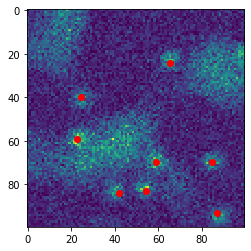

In [138]:
idx = 1
init = 0
init_1 = 0
size = 100
image = test_x[idx]
image = image[init:(init+size),init_1:(init_1+size)]
mask = test_y[idx]
mask = mask[int(init/4):int((init+size)/4),int(init_1/4):int((init_1+size)/4)]

plt.imshow(image)
coordList = get_coordinate_list(mask,512,128)
plt.scatter(coordList[...,0],coordList[...,1],marker="+",color='r',s=20)
plt.scatter(y0,x0,marker="+",color='b',s=20)


In [83]:
start_dim1 = np.max(int(np.round(y_coord - cell_size // 2)), 0)


In [92]:
end_dim1 = np.min([start_dim1 + cell_size, len(image) - 1])

In [93]:
end_dim1

27

In [ ]:
start_dim1 = np.max(int(np.round(y_coord - cell_size // 2)), 0)
end_dim1 = np.min(start_dim1 + cell_size, len(image) - 1)

start_dim2 = np.max(int(np.round(x_coord - cell_size // 2)), 0)
end_dim2 = np.min(start_dim2 + cell_size, len(image) - 1)
crop = image[start_dim1:end_dim1, start_dim2:end_dim2]    

x = np.arange(0, crop.shape[1], 1)
y = np.arange(0, crop.shape[0], 1)
xx, yy = np.meshgrid(x, y)

# Guess intial parameters
x0 = int(crop.shape[0]//2) # Middle of the crop
y0 = int(crop.shape[1]//2) # Middle of the crop
sigma = max(*crop.shape) * 0.1 # 10% of the crop
H = np.max(crop)/2 # Maximum value of the crop
initial_guess = [H, x0, y0, sigma, 0]

lower = [0, 0, 0, 0, 0]
upper = [np.max(crop), crop.shape[0], crop.shape[1], np.inf, np.max(crop)]
bounds = [lower, upper]

popt, pcov = opt.curve_fit(twoD_Gauss, (xx.ravel(),yy.ravel()), crop.ravel(), p0 = initial_guess, bounds=bounds)
x0 = popt[1] + start_dim2
y0 = popt[2] + start_dim1

return x0, y0